### Handling imbalanced data in customer churn prediction
Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model. We will then handle imbalance in data using various techniques and improve f1-score

##### *********************** Below portion same as 6_CustomerChurnPrediction code ***************************

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6452,9529-OFXHY,Male,0,No,No,15,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),87.75,1242.2,No
6353,8735-DCXNF,Male,0,Yes,No,10,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),54.95,568.85,No
1090,9036-CSKBW,Female,0,No,No,51,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),107.45,5680.9,No
2176,2626-VEEWG,Male,0,Yes,Yes,67,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.40,1284.2,No
3951,5915-ANOEI,Male,0,Yes,No,70,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,79.15,5536.5,No


In [4]:
# dropping customerID column as it is of no use
df.drop('customerID',axis='columns',inplace=True)
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges should be float but it is an object. Let's check what's going on with this colum 

In [5]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

it is string. Let's convert it to numbers

In [6]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

In [ ]:
# some values seem to be not numbers but blank string. Let's find out such rows
df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]

In [7]:
# Remove rows with space in TotalCharges. (Only 10 rows)
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [8]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

##### For some data insights, let us se what is the relationship between tenure and churn rate

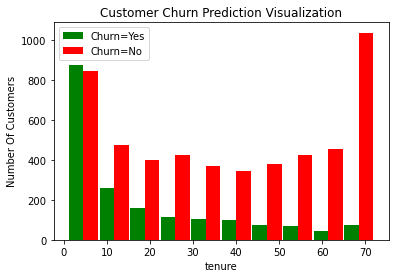

In [9]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualization")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green','red'], label=['Churn=Yes','Churn=No'])
plt.legend()

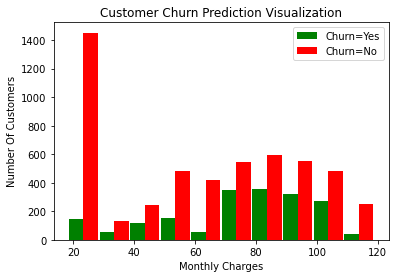

In [10]:
# relationship with MonthlyCharges
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualization")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'], label=['Churn=Yes','Churn=No'])
plt.legend()

In [11]:
# Many of the columns are yes, no etc. Let's print unique values in object columns to see data values
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [12]:
# Some of the columns have 'no internet service' or 'no phone service', that can be replaced with a simple No
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [13]:
# Converting Yes and No to 1 or 0
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0}, inplace=True)

In [14]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [15]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

In [16]:
# One hot encoding for categorical columns
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [17]:
# scaling columns that have other than 0 and 1 values
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

In [18]:
# train-test split
X = df2.drop('Churn', axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

X_train.shape, y_train.shape

((5625, 26), (5625,))

In [19]:
len(X_train.columns)

26

##### *********************** Above portion same as 6_CustomerChurnPrediction code ***************************

#### Build a model (ANN) in tensorflow/keras

In [35]:
# from tensorflow_addons import losses

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

In [36]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [37]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
176/176 [==============================] - 1s 1ms/step - loss: 0.5718 - accuracy: 0.6837
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.7925: 0s - loss: 0.4282 - accuracy: 0.79
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8110
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.8034
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8104
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4097 - accuracy: 0.8017
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8067
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8071
Epoch 9/100
176/176 [==============================] - 0s 1ms/step - loss: 0.3991 - accuracy: 0.8120
Epoch 10/100
176/176 [==============================] -

The precision and recall scores for 1 are low.

### Mitigating Skewdness of Data

##### 1. Undersampling

In [39]:
# Class count
count_class_0, count_class_1 = df1.Churn.value_counts()

# Divide by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [40]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
1    1869
0    1869
Name: Churn, dtype: int64


In [41]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

# Number of classes in training Data
y_train.value_counts()

1    1495
0    1495
Name: Churn, dtype: int64

In [42]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 944us/step - loss: 0.6864 - accuracy: 0.5704
Epoch 2/100
94/94 [==============================] - 0s 944us/step - loss: 0.5284 - accuracy: 0.7556
Epoch 3/100
94/94 [==============================] - 0s 933us/step - loss: 0.5065 - accuracy: 0.7524
Epoch 4/100
94/94 [==============================] - 0s 879us/step - loss: 0.4820 - accuracy: 0.7679
Epoch 5/100
94/94 [==============================] - 0s 879us/step - loss: 0.4904 - accuracy: 0.7638
Epoch 6/100
94/94 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.75 - 0s 858us/step - loss: 0.5006 - accuracy: 0.7571
Epoch 7/100
94/94 [==============================] - 0s 890us/step - loss: 0.4948 - accuracy: 0.7577
Epoch 8/100
94/94 [==============================] - 0s 836us/step - loss: 0.4846 - accuracy: 0.7632
Epoch 9/100
94/94 [==============================] - 0s 987us/step - loss: 0.4783 - accuracy: 0.7655
Epoch 10/100
94/94 [=============================

Check classification report above. f1-score for minority class 1 improved from **0.57** to **0.76**. Score for class 0 reduced to 0.75 from 0.84 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score

#### 2. Oversampling

In [43]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
1    5163
0    5163
Name: Churn, dtype: int64


In [44]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

In [45]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 1s 850us/step - loss: 0.6069 - accuracy: 0.6723
Epoch 2/100
259/259 [==============================] - 0s 935us/step - loss: 0.5026 - accuracy: 0.7514
Epoch 3/100
259/259 [==============================] - 0s 816us/step - loss: 0.4923 - accuracy: 0.7575
Epoch 4/100
259/259 [==============================] - 0s 912us/step - loss: 0.4797 - accuracy: 0.7644
Epoch 5/100
259/259 [==============================] - 0s 947us/step - loss: 0.4842 - accuracy: 0.7680
Epoch 6/100
259/259 [==============================] - 0s 916us/step - loss: 0.4716 - accuracy: 0.7670
Epoch 7/100
259/259 [==============================] - 0s 820us/step - loss: 0.4702 - accuracy: 0.7686
Epoch 8/100
259/259 [==============================] - 0s 804us/step - loss: 0.4676 - accuracy: 0.7732
Epoch 9/100
259/259 [==============================] - 0s 785us/step - loss: 0.4583 - accuracy: 0.7833
Epoch 10/100
259/259 [==============================] - 0s 862us/step - l

Check classification report above. f1-score for minority class 1 improved from **0.57** to **0.80**. Score for class 0 reduced to 0.75 from 0.85 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score

#### 3: SMOTE
To install imbalanced-learn library use pip install imbalanced-learn command

In [46]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts()

1    5163
0    5163
Name: Churn, dtype: int64

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

In [50]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 1s 827us/step - loss: 0.6437 - accuracy: 0.6278
Epoch 2/100
259/259 [==============================] - 0s 792us/step - loss: 0.4759 - accuracy: 0.7759
Epoch 3/100
259/259 [==============================] - 0s 835us/step - loss: 0.4598 - accuracy: 0.7856
Epoch 4/100
259/259 [==============================] - 0s 850us/step - loss: 0.4602 - accuracy: 0.7836
Epoch 5/100
259/259 [==============================] - 0s 897us/step - loss: 0.4443 - accuracy: 0.7934
Epoch 6/100
259/259 [==============================] - 0s 847us/step - loss: 0.4515 - accuracy: 0.7842
Epoch 7/100
259/259 [==============================] - 0s 831us/step - loss: 0.4406 - accuracy: 0.7958
Epoch 8/100
259/259 [==============================] - 0s 935us/step - loss: 0.4268 - accuracy: 0.8003
Epoch 9/100
259/259 [==============================] - 0s 951us/step - loss: 0.4368 - accuracy: 0.7972
Epoch 10/100
259/259 [==============================] - 0s 959us/step - l

SMOTE Oversampling increases f1 score of minority class 1 from **0.57** to **0.81** (huge improvement) Also over all accuracy improves from 0.78 to 0.80

#### 4: Use of Ensemble with undersampling

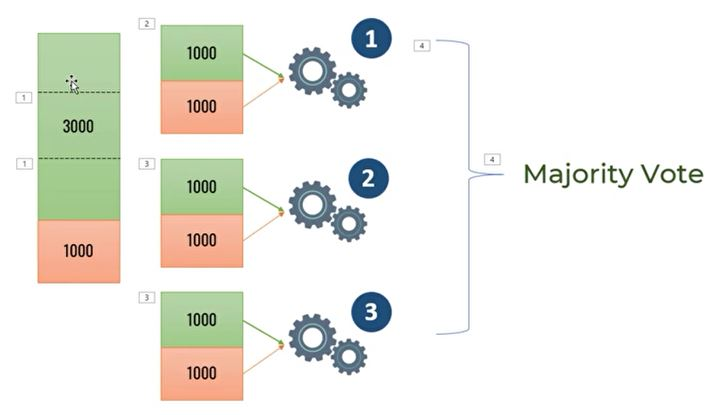

In [52]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "ensemble.jpg", width = 700, height = 500)

In [53]:
# original data with imbalanced classes
df2.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [54]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

##### model1 --> class1(1495) + class0(0, 1495)
##### model2 --> class1(1495) + class0(1496, 2990)
##### model3 --> class1(1495) + class0(2990, 4130)

In [55]:
df3 = X_train.copy()
df3['Churn'] = y_train

df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

# creates different batches for the 0 class data
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train

In [56]:
# model1 
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 1ms/step - loss: 0.6753 - accuracy: 0.5758
Epoch 2/100
94/94 [==============================] - 0s 997us/step - loss: 0.5239 - accuracy: 0.7629
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.7705
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4995 - accuracy: 0.7672
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.7650
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4749 - accuracy: 0.7729
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4892 - accuracy: 0.7640
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7686
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4629 - accuracy: 0.7878
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4737 - accuracy: 0.7783
Epoch 1

In [57]:
# model2
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 1ms/step - loss: 0.6909 - accuracy: 0.5349
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.7541
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4933 - accuracy: 0.7687
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4916 - accuracy: 0.7587
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.7604
Epoch 6/100
94/94 [==============================] - 0s 922us/step - loss: 0.4897 - accuracy: 0.7530
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4798 - accuracy: 0.7618
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4727 - accuracy: 0.7705
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4597 - accuracy: 0.7761
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4649 - accuracy: 0.7769
Epoch 1

In [58]:
# model3
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 [==============================] - 1s 1ms/step - loss: 0.6712 - accuracy: 0.6100
Epoch 2/100
83/83 [==============================] - 0s 924us/step - loss: 0.5445 - accuracy: 0.7645
Epoch 3/100
83/83 [==============================] - 0s 1ms/step - loss: 0.5038 - accuracy: 0.7630
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.7757
Epoch 5/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4682 - accuracy: 0.7849
Epoch 6/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4610 - accuracy: 0.7919
Epoch 7/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7784
Epoch 8/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4577 - accuracy: 0.7842
Epoch 9/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.7894
Epoch 10/100
83/83 [==============================] - 0s 901us/step - loss: 0.4633 - accuracy: 0.7825
Epoch

In [59]:
len(y_pred1)

1407

In [60]:
# predicting the final values based ont he three model outputs
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [61]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1033
           1       0.49      0.76      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



##### The best method turns out to be SMOTE and it gives the best F1 score for this data.